<a href="https://colab.research.google.com/github/john-s-butler-dit/Basic-Introduction-to-Python/blob/master/W2%20Spiking%20Model%20-%20Izhikevch%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Interactive Izhikevich Model
======
Technical Report 
------
Content: John S Butler*, Micheal Clerkin, James Kinsela

School of Mathematical Sciences

*corresponding email address: john.s.butler@tudublin.ie

#### Abstract
This notebook implements an interative version of the computatonal neuronal model proposed by [Eugene M Izhikevich](https://www.izhikevich.org/publications/spikes.htm) [1] which simulates a variety of neuronal behaviour from tonic spiking to rezonating of a single neuron.

## Introduction
The Izihkevich model is biologically plausible and  computationally simple.
Here, we will focus on the ability of the simple spiking model to simulate a wide variety of various neuronal firing patterns observed experimentally (Figure 1 Modified from Markram et al). The computational simplicitly allows for the simulation of large networks of spiking neurons, this will be addressed in another notebook, here we will focus on a single neuron.
<img src="https://github.com/john-s-butler-dit/Basic-Introduction-to-Python/blob/master/x150.png" alt="Neuronal Firing Type" style="width: 400px;"/>
<em><center> Figure 1: Multiple firing patterns in cortical neurons. For each type, the neuron is stimulated with a step current with low or high amplitude. Modified from Markram et al. </center></em>

This notebook follows the stucture of the Izhikevich 2003 paper [1]:
* Firstly, describing the continuous differential equation, the parameters and inputs;  
* Secondly, discretising the model such that it can be simulated computationally;  
* Finally, illustating how different parameter yield different firing patterns.

The notebook will be interspersed with python code cells to simulate the neuron.

#### Code libraries
The cell below sets up the python libraries need for the code and plotting the output.

In [1]:
# LIBRARY
# vector manipulation
import numpy as np
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd

## The Izihkevich Model
The Izihkevich model is a system of two first order non-linear differential equations:
\begin{equation}  \frac{dv}{dt} = 0.04v^2+5v+140-u+I, \end{equation}
\begin{equation}\frac{du}{dt} = a(bv-u),\end{equation}.

Where $u$ and $v$ are dimensionless variables, $I$ is the input to the system and $a$ and $b$ are dimesionless parameters which are maniputled to descibe different firing patterns (see next section). 

The variable $v$ is of most interest as it represents the membrane potential of the neuron in microvolts ($mV$) and $u$ represents a membrane recovery variable, which accounts for the activation of $K^{+}$
ionic currents and inactivation of $Na^{+}$ ionic currents, and it provides negative feedback to $v$. 

After the spike reaches its apex (30 mV), the
membrane voltage and the recovery variable are reset according  
if $v\geq 30mV$ then
\begin{equation}  v \leftarrow c, \end{equation}
\begin{equation} u \leftarrow u+d.\end{equation}

### Parameters of the model
By changing parameters $a$, $b$, $c$ and $d$ different firing patterns can be simulated. Each parameter corresponds to different aspects of neural behaviour:

a. The parameter  $a$ describes the time scale of the recovery variable $u$.
Smaller values result in slower recovery time. 

b. The parameter $b$ describes the sensitivity of the recovery variable
to the subthreshold fluctuations of the membrane potential $v$.

c. The parameter $c$ describes the after-spike reset value of the membrane
potential $v$ caused by the fast high-threshold $K^{+}$ conductances.

d. The parameter $d$ describes after-spike reset of the recovery variable $u$
caused by slowhigh-threshold $Na^{+}$ and $K^{+}$conductances.

### Model Input
For simplicities sake the input to model (I(t)) is a step function that is 0 mV from 0ms to 300 ms then steps to 5mV from 300ms to 1000ms.  

In the cell below the: 
* To change the onset of the step, change the variable input_onset;
* To change the amplitude of the step, change the variable input_amp.

See the Figure 2 for an example of the input to the system.

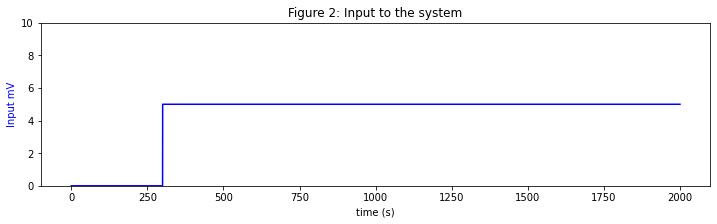

In [2]:
#### Model Input
h=0.005 #step size
input_onset=300             # Onset of input
input_amp=5                 # AMPLITUDE OF INPUT
total_time=2000             # Total simulation time in ms

time=np.arange(0,total_time,h)  # time period 1000ms (1s)
fs=1000/h 

def Input(input_onset,input_amp):
    I=np.zeros((len(time)))     # CURRENT (INPUT)

    for k in range (0,len(time)):
        if time[k] >input_onset:
            I[k]=input_amp # Input change
    return I

# PLOTTING THE INPUT    
fig, ax1 = plt.subplots(figsize=(12,3))
ax1.plot(time, Input(input_onset,input_amp), 'b-') # y label
ax1.set_xlabel('time (s)') # x label
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Input mV', color='b')
ax1.set_ylim(0,input_amp*2) # setting the plotting range
plt.title('Figure 2: Input to the system')
plt.show()   

## Methods
### Numerical Solution
The system of differential equations describe in the previous section is non-linear and has no known exact solution, hence the solution has to be numerically approximated. The simplest numerical method is the Euler method (https://en.wikipedia.org/wiki/Euler_method) which approximates the first derivate by the formula of the slope of a line at two time points $t$ and $t+h$, where $h$ is a small step in time:
\begin{equation}  \frac{dv}{dt} \approx \frac{v(t+h)-v(t)}{t+h-t}=\frac{v(t+h)-v(t)}{h}. \end{equation}
Using this method the Izhikecich equations can be re-written as 
\begin{equation}   \frac{v(t+h)-v(t)}{h} \approx 0.04v^2+5v+140-u+I, \end{equation}
\begin{equation} \frac{u(t+h)-u(t)}{h} \approx a(bv-u)
.\end{equation}
By re-arranging these equations to  numerically approximate the solution $v(t+h)$ and $u(t+h)$ at time $t+h$ using the solutions $u(t)$ and $v(t)$  and input $I(t)$ at time $t$, such that,
\begin{equation}   v(t+h) \approx v(t)+h(0.04v(t)^2+5v(t)+140-u(t)+I(t)), \end{equation}
\begin{equation} u(t+h)\approx u(t)+h(a(bv(t)-u(t))).\end{equation}
The smaller the time step $h$ between two time points the more accurate the method, here $h=0.5ms$.

In the cell below is the function DiscreteModel is the numerical Differential Equation which gives the approximate numerical solution of $u$, and $v$ at time point $t+h$. The function takes in the parameters $a$ and $b$, and the approximate numerical solution of $u$, and $v$ at time point $t$. 

In [3]:
# Numerical Solution to the Izhikevich model
def Discrete_Model(a,b,u,v,I):
    v = v + h *(0.04*v*v+5*v+140-u+I) # Discrete form of membrane potential of the neuron 
    u = u + h *(a*(b*v-u))            # Discrete form of membrane recovery variable
    return u,v      

### The main code
The cell below is the main python function for the Izhikevich model. The function takes in four variables a, b ,c and d coresponding to the parameters in to model of the same namesake. 

In [4]:
def Izhikevich(a,b,c,d):
    v=-65*np.ones((len(time)))  # SETS UP THE INITIAL VALUES of the membrane potential
    u=0*np.ones((len(time)))    # SETS UP THE INITIAL VALUES of the membrane recovery
    u[0]=b*v[0]                 # INITIAL CONDITION 
    
    spiketime=[]
    fired=[]
    firing_time=[]

    I=Input(input_onset,input_amp)
    # EULER METHOD
    for k in range (0,len(time)-1):
        u[k+1],v[k+1]=Discrete_Model(a,b,u[k],v[k],I[k]) # Numerically solving the equations at each time point
           
        if v[k+1]>30:
            v[k+1]=c
            u[k+1]=u[k+1]+d
            firing_time.append(time[k])
    plot_input_output(time,v,I,a,b,c,d,firing_time)
    w=(v-v.min())
    w=w/(1.1*w.max())

    return w

#### Plotting Results Code
In the cell below is the plotting function for the Input (I) and output (v) of the Izhikevich model. The function takes in time, output (v), input (I) and the four variables a, b ,c and d coresponding to the parameters in to model of the same lettersake.


In [5]:
def plot_input_output(time,v,I,a,b,c,d,firing_time):   
    # PLOTTING
    fig, ax1 = plt.subplots(figsize=(12,3))
    ax1.plot(time, v, 'b-', label = 'Output')
    ax1.set_xlabel('time (ms)')
    # Make the y-axis label, ticks and tick labels match the line color.
    # Plotting out put 
    ax1.set_ylabel('Output mV', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim(-95,40)
    ax2 = ax1.twinx()
    # Plotting input on a different axis
    ax2.plot(time, I, 'r', label = 'Input')
    ax2.set_ylim(0,input_amp*20)
    ax2.set_ylabel('Input (mV)', color='r')
    ax2.tick_params('y', colors='r')
    
    fig.tight_layout()
    ax1.legend(loc=1)
    ax2.legend(loc=3)
    ax1.set_title('Parameters a %s b: %s c:  %s d:  %s' %(a,b,c,d))
    plt.show()
    
        # PLOTTING
    fig, ax = plt.subplots(figsize=(12,3))
    #plt.histogram(np.diff(firing_time), bins='auto')  # arguments are passed to np.histogram
    np.diff(firing_time)
    plt.hist(np.diff(firing_time))
    plt.title("Inter-spike Interval")
    plt.xlim(0,100)
    plt.xlabel('time (ms)')
    plt.ylabel('Spike Count')
    plt.show()
   
 

## Results 
The results section plots each of the different firing patterns from different parameters:


| Neuron | a   | b | c | d|
|------|------|------|------|------|
|   Regular Spiking (RS) | 0.02|0.2|-65|8|
|   Intrinsically Bursting (IB) | 0.02|0.2|-55|4|
|   Chattering (CH) | 0.02|0.2|-50|2|
|   Fast Spiking (FS) | 0.1|0.2|-65|2|
|   Thalamo-cortical (TC) | 0.02|0.25|-65|0.05|
|   Resonator (RZ) | 0.1|0.26|-65|2|
|   Low-threshold Spiking (LTS) | 0.02|0.25|-65|2|

The cells below show the results of the simulations for a two second interval for the different types of the neuronal firing describe in the table.
Each cell represents the neuronal simulation in three different ways:
1. Plots the output of the model, v (mV), in blue and the input of the model, I (mV), in red as a function of time in miliseconds (ms).
2. The inter-spike interval for the neuron.
3. As electrophysiolgists listen to neurons during experiments the output has also been converted to an audio file. 

The parameters of the model can be changed to illustrate the flexibility of the model to simulate different spiking behaviour. 

## Excitatory Cortical Cells

### Regular Spiking

| Neuron | a   | b | c | d|
|------|------|------|------|------|
|   Regular Spiking (RS) | 0.02|0.2|-65|8|


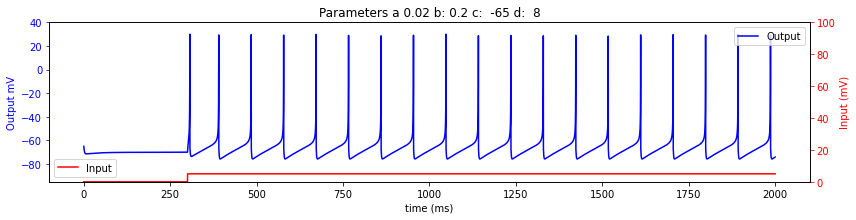

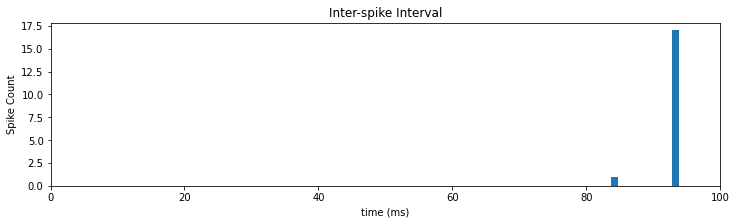

In [6]:
u=Izhikevich(0.02,0.2,-65,8)

ipd.Audio(u, rate=1000/h)

### Intrinsically Bursting

| Neuron | a   | b | c | d|
|------|------|-------|------|------|
|   Intrinsically Bursting (IB) | 0.02|0.2|-55|4|

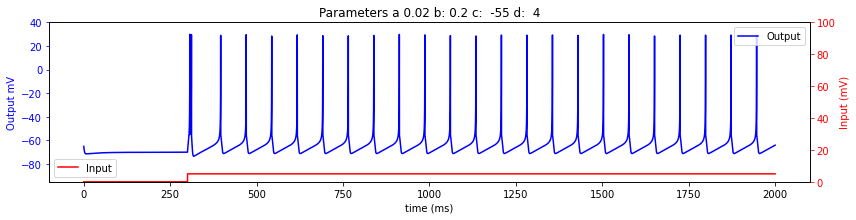

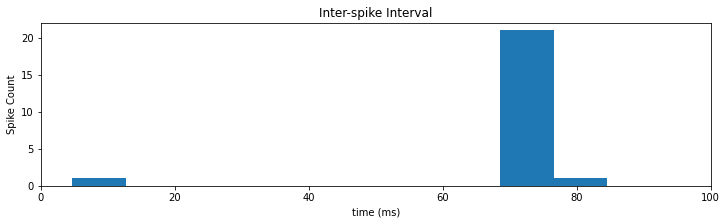

In [7]:
u=Izhikevich(0.02,0.2,-55,4)

ipd.Audio(u, rate=1000/h)

### Chattering

| Neuron | a   | b | c | d|
|------|------|-------|------|------|
|   Chattering (CH) | 0.02|0.2|-50|2|


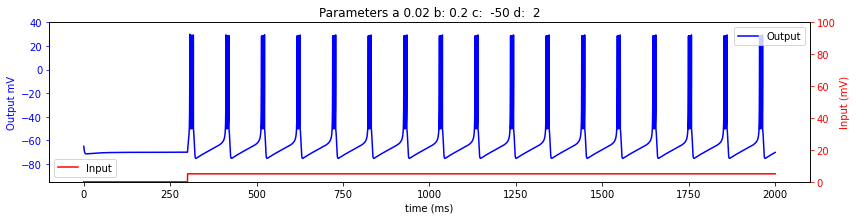

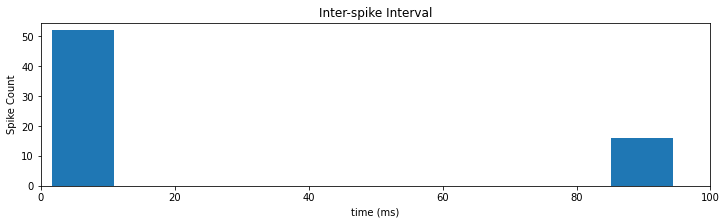

In [8]:
u=Izhikevich(0.02,0.2,-50,2)

ipd.Audio(u, rate=1000/h)

### Inhibitory Cortical Cells
#### Fast Spiking

| Neuron | a   | b | c | d|
|------|------|------|------|------|
|   Fast Spiking (FS) | 0.1|0.2|-65|2|


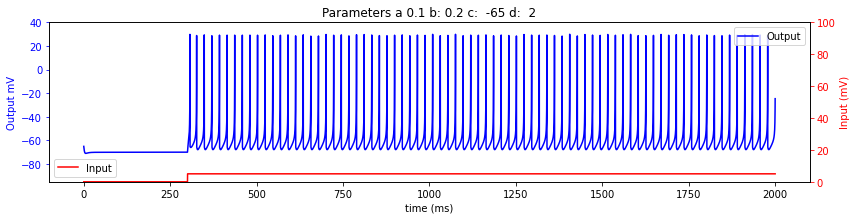

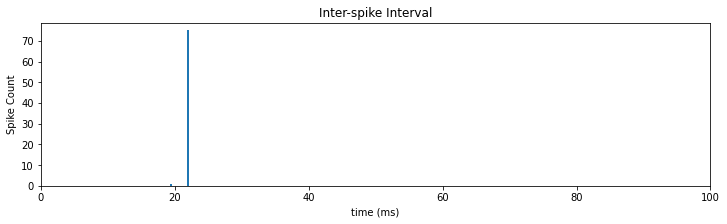

In [9]:
u=Izhikevich(0.1,0.2,-65,2)

ipd.Audio(u, rate=1000/h)

### Low-threshold Spiking
| Neuron | a   | b | c | d|
|------|------|-------|------|------|
|   Low-threshold Spiking (LTS) | 0.02|0.25|-65|2|

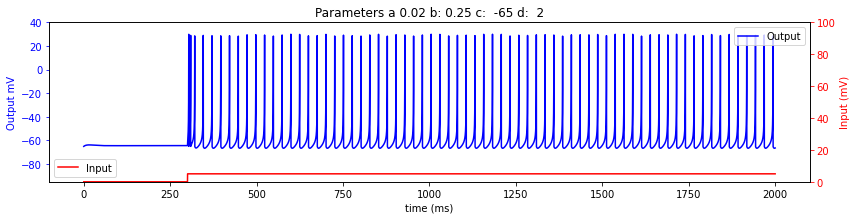

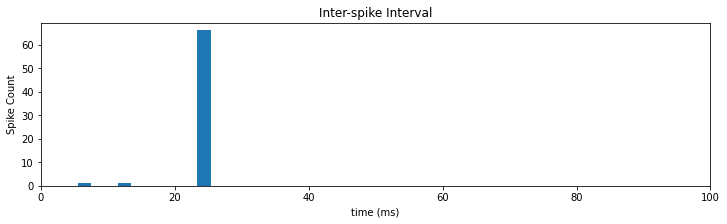

In [10]:
u=Izhikevich(0.02,0.25,-65,2)

ipd.Audio(u, rate=1000/h)

### Other Firing Patterns
### Thalamo-cortical 
| Neuron | a   | b | c | d|
|------|------|-------|------|------|
|   Thalamo-cortical (TC) | 0.02|0.25|-65|0.05|


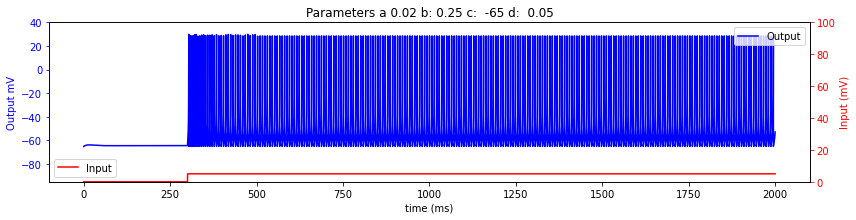

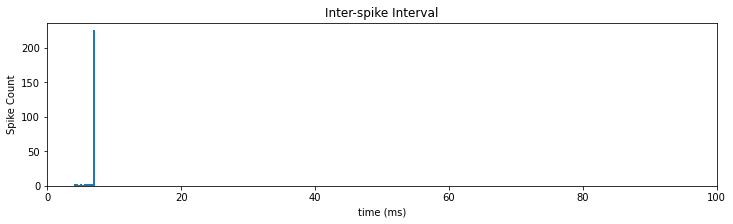

In [11]:
u=Izhikevich(0.02,0.25,-65,0.05)

ipd.Audio(u, rate=1000/h)

### Resonator
| Neuron | a   | b | c | d|
|------|------|------|------|------|
|   Resonator (RZ) | 0.1|0.26|-65|2|


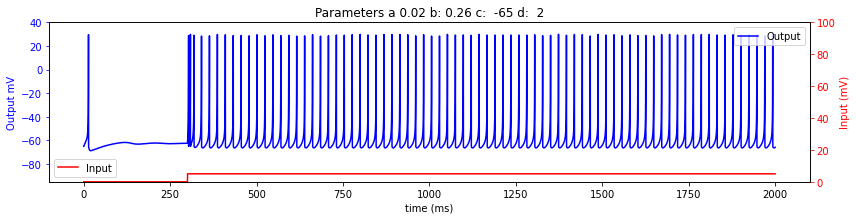

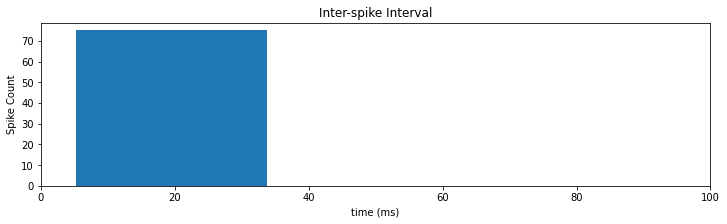

In [12]:
u=Izhikevich(0.02,0.26,-65,2)

ipd.Audio(u, rate=1000/h)

#### References

[1] Izhikevich EM. 2003. Simple model of spiking neurons. IEEE Trans Neural Netw 14:1569-1572.

[2] Markram H, Toledo-Rodriguez M, Wang Y, Gupta A, Silberberg G, Wu C. 2004. Interneurons of the neocortical inhibitory system. Nat Rev Neurosci 5:793-807.



